In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

### LB Keogh

To use the _LB Keogh_ lower bound of dynamic time warping

$$
\begin{split}LB_{Keogh}(Q, (L, U)) = \sqrt{\sum_{i=1}^n
\begin{cases}
      (q_i - u_i)^2 & \text{if $q_i > u_i$}\\
      (q_i - l_i)^2 & \text{if $q_i < l_i$}\\
      0 & \text{otherwise}
\end{cases}
}\end{split}
$$

where $U_i$ and $L_i$ are upper and lower bounds for time series $Q$ which are defined as $U_i=max(q_{i-r}:q_{i+r})$ and $L_i=min(q_{i-r}:q_{i+r})$ for a reach $r$. It can be implemented with the following function.

In [2]:
def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):
        
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        
        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    
    return np.sqrt(LB_sum)

### Data and Pre-processing

Using datasets from A. Bagnall, J. Lines, W. Vickers and E. Keogh, The UEA & UCR Time Series Classification Repository, www.timeseriesclassification.com

In this example, time series are preprocessed using TimeSeriesScalerMeanVariance. This scaler is such that each output time series has zero mean and unit variance. The assumption here is that the range of a given time series is uninformative and one only wants to compare shapes in an amplitude-invariant manner (when time series are multivariate, this also rescales all modalities such that there will not be a single modality responsible for a large part of the variance). This means that one cannot scale barycenters back to data range because each time series is scaled independently and there is hence no such thing as an overall data range.

[1] F. Petitjean, A. Ketterlin & P. Gancarski. A global averaging method for dynamic time warping, with applications to clustering. Pattern Recognition, Elsevier, 2011, Vol. 44, Num. 3, pp. 678-693 [2] M. Cuturi, M. Blondel “Soft-DTW: a Differentiable Loss Function for Time-Series,” ICML 2017.

In [3]:
!pip install tslearn
from tslearn.datasets import CachedDatasets

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

np.random.seed(42)
X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
X_train = X_train[y_train < 4]  # Keep first 3 classes
y_train = y_train[y_train < 4]
y_train = y_train-1

#np.random.shuffle(X_train)
indices = np.arange(X_train.shape[0])
indices = np.random.shuffle(indices)
X_train = X_train[indices][0]
y_train = y_train[indices][0]

# Keep only 50 time series
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train[:50])
y_train = y_train[:50]
# Make time series shorter
X_train = TimeSeriesResampler(sz=40).fit_transform(X_train)
sz = X_train.shape[1]

/home/mark/.conda/envs/data/lib/python3.8/site-packages/tslearn/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
/home/mark/.conda/envs/data/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


Now visulize our data

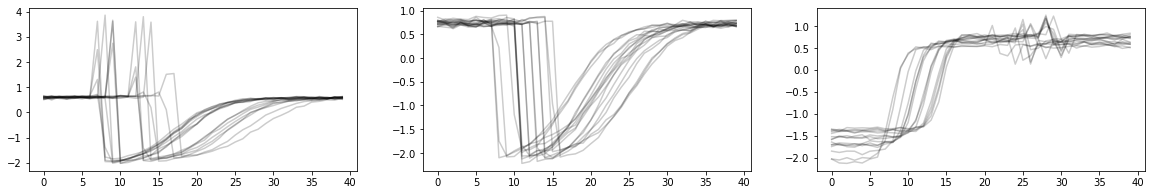

In [4]:
plt.figure(figsize=(20,3))
for yi in range(3):
    plt.subplot(1, 3, yi+1)
    for xx in X_train[y_train == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)

Note that we only use some data from tslearn package and from now on all parts should not be relying on it.

### Time Series K-Means Clustering

Normally a K-Means Clustering takes the mean value of each cluster as its centroid in each iteration. An wrong example of time series is given below.

In [5]:
def k_means_clust(X,num_clust,num_iter):
    
    # initial random centroids   
    centroids = random.sample(list(X),num_clust)

    for n in tqdm(range(num_iter)):
        y_pred = []
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(X_train):
            min_dist=float('inf')
            closest_clust=None
            for cluster_id,centroid in enumerate(centroids):
                if LB_Keogh(i,centroid,10)<min_dist:
                    cur_dist=LB_Keogh(i,centroid,10)
                    if cur_dist<min_dist:
                        min_dist=cur_dist
                        closest_clust=cluster_id
                        
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust]=[]
            y_pred.append(closest_clust)
            
        #recalculate centroids of clusters using simple average of time series
        for key in assignments:
            clust_sum=0
            for k in assignments[key]:
                clust_sum=clust_sum+X[k]
            
            if len(assignments[key])>0:
                centroids[key]=clust_sum/len(assignments[key])
                
    return np.array(y_pred), centroids 

In [6]:
y_pred, centroids=k_means_clust(X_train,3,10)

100%|██████████| 10/10 [00:02<00:00,  3.97it/s]


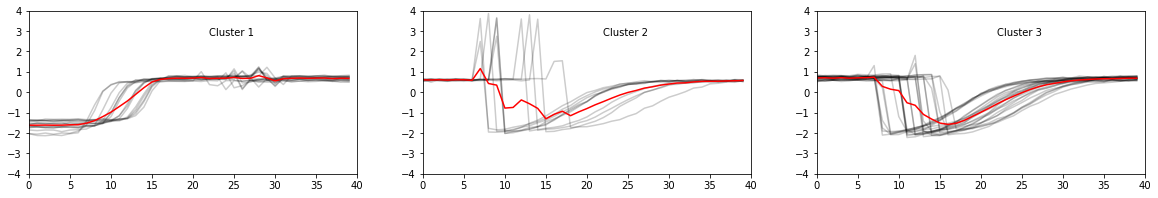

In [7]:
plt.figure(figsize=(20,3))

for yi in range(3):
    plt.subplot(1, 3, yi+1)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(centroids[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("")

Calculate the clustering accuracy

In [8]:
accuracy = 0
for i in [0,1,2]:
    temp = sum(np.mod(y_pred+i,3) == y_train)/len(y_train)
    if accuracy < temp:
        accuracy = temp
print(accuracy)

0.86


Does the result meet your expectation? Why is it so? Type your answer below.

As expected, due to the unique property of time series data, the centroid calculated by simple average shows little meanning and the clutering result is visually not good.

---

Now recall that a centroid of a cluster of points is a point that minimize the mean square of distances to other points in its cluster, a centroid of a time series should share a similar property. In previous parts, we have seen the appropriate tool to describe distance between 2 time series. With this in mind, finish the following part.

Hint: such time series centroid can be one member of its cluster.

In [9]:
def lb_k_means_clust(X,num_clust,num_iter):
    
    # initial random centroids   
    centroids = random.sample(list(X),num_clust)

    for n in tqdm(range(num_iter)):
        y_pred = []
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(X_train):
            min_dist=float('inf')
            closest_clust=None
            for cluster_id,centroid in enumerate(centroids):
                if LB_Keogh(i,centroid,10)<min_dist:
                    cur_dist=LB_Keogh(i,centroid,10)
                    if cur_dist<min_dist:
                        min_dist=cur_dist
                        closest_clust=cluster_id
                        
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust]=[]
            y_pred.append(closest_clust)
            
            #recalculate centroids of clusters using LB Keogh
            ### BEGIN CODE ###
            for cluster_id in assignments:
                clust_sum=0
                LB_Keogh_sum = np.zeros(len(assignments[cluster_id]))
                for sid, s1 in enumerate(assignments[cluster_id]):
                    for s2 in assignments[cluster_id]:
                        LB_Keogh_sum[sid] = LB_Keogh_sum[sid] + LB_Keogh(X[s1],X[s2],10)
                if len(LB_Keogh_sum)>0:
                    centroids[cluster_id] = np.ndarray.flatten(X[assignments[cluster_id][np.argmin(LB_Keogh_sum)]])
            ### END CODE ###
            
    return np.array(y_pred), centroids 

In [10]:
y_pred, centroids=lb_k_means_clust(X_train,3,10)

100%|██████████| 10/10 [01:50<00:00, 11.01s/it]


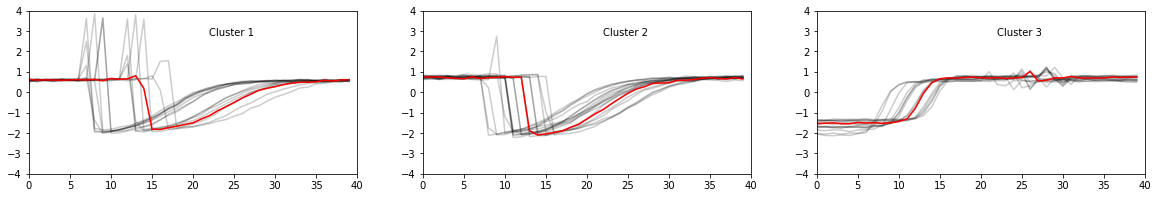

In [11]:
plt.figure(figsize=(20,3))

for yi in range(3):
    plt.subplot(1, 3, yi+1)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(centroids[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("")

Calculate the clustering accuracy

In [12]:
accuracy = 0
for i in [0,1,2]:
    temp = sum(np.mod(y_pred+i,3) == y_train)/len(y_train)
    if accuracy < temp:
        accuracy = temp
print(accuracy)

0.98
